In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from google.colab import drive



In [2]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import os
os.chdir("drive/My Drive")
os.listdir(os.getcwd())

['Colab Notebooks', 'Project_1', 'Deep-Autoencoder-using-Tensorflow-master']

In [0]:
train_size = 800
test_size = 200
im_list = []
lms_list = []
train_im_list = []
test_im_list = []
train_lm_names = []
test_lm_names = []

from scipy.io import loadmat

my_folder = 'Project_1'
im_list = os.listdir(my_folder+"/images")
im_list.sort()
del im_list[im_list.index(".DS_Store")]
lms_list = os.listdir(my_folder+"/landmarks")
lms_list.sort()

no_landmarks = 68
count1 = 0
count2 = 0
X_landmarks = np.zeros(shape=(train_size,no_landmarks,2),dtype=float, order='C')
X_landmarks_test = np.zeros(shape=(test_size,no_landmarks,2),dtype=float, order='C')
X_landmarks_sub_mean = np.zeros(shape=(train_size,no_landmarks,2),dtype=float, order='C')
X_landmarks_test_sub_mean = np.zeros(shape=(test_size,no_landmarks,2),dtype=float, order='C')

for child in lms_list:
    lmdict = loadmat(my_folder + "/landmarks/" + child)
    lms = lmdict['lms']
    if count1<train_size:
        X_landmarks[count1,:,:] = lms
        train_lm_names = train_lm_names + [child]
    else:
        X_landmarks_test[count2,:,:] = lms
        test_lm_names = test_lm_names + [child]
        count2 +=1
    count1 += 1
    

#print(X_landmarks.shape)    (800, 68, 2)
#print(X_landmarks_test.shape)    (200, 68, 2)

X_landmarks_mean = np.mean(X_landmarks, axis=0)
#print(X_landmarks_mean.shape)   (68, 2)

In [0]:
for i in range(800):
    X_landmarks_sub_mean[i,:,:] = X_landmarks[i] - X_landmarks_mean
    
#print(X_landmarks_sub_mean.shape)    (800, 68, 2)

for i in range(200):
    X_landmarks_test_sub_mean[i,:,:] = X_landmarks_test[i] - X_landmarks_mean
    
#print(X_landmarks_test_sub_mean.shape)    (200, 68, 2)

In [9]:
!pip install imageio
from Project_1 import mywarper

    100% |████████████████████████████████| 3.3MB 10.3MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


In [10]:
len(im_list)

1000

In [0]:
pixel_size = 128
import cv2

count1 = 0
count2 = 0
training_im_list = []
test_im_list = []
X = np.zeros(shape=(train_size,pixel_size,pixel_size,3),dtype=float, order='C')
X_test = np.zeros(shape=(test_size,pixel_size,pixel_size,3),dtype=float, order='C')
for child in im_list:
    im = cv2.imread(my_folder+"/images/" + child)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    warpedim = mywarper.warp(im, loadmat(my_folder+"/landmarks/"+lms_list[count1])['lms'], X_landmarks_mean)
    warpedim = (warpedim - np.min(warpedim))/ (np.max(warpedim) - np.min(warpedim))
    #print(warpedim.shape)    (128,128,3)
    if count1 < train_size:
        X[count1] = warpedim
        training_im_list += [child]
    else:
        X_test[count2] = warpedim
        test_im_list += [child]
        count2 += 1
    count1 = count1+1
    
#print(X.shape)    (800, 128, 128, 3)
#print(X_test.shape)    (200, 128, 128, 3)


In [0]:
X_landmarks_norm = np.zeros(shape=(train_size,no_landmarks,2),dtype=float, order='C')
X_landmarks_test_norm = np.zeros(shape=(test_size,no_landmarks,2),dtype=float, order='C')

for i in range(800):
  X_landmarks_norm[i] = X_landmarks[i]/128
  
for i in range(200):
  X_landmarks_test_norm[i] = X_landmarks_test[i]/128

In [0]:
#Autoencoder for Landmarks
#Fully connected layers 

X_lm = tf.placeholder(tf.float32, [None, 68, 2])

batch_size = 100

#Encoder

with tf.name_scope("Encoder"):
  lm_x1_1_fc = tf.contrib.layers.fully_connected(tf.contrib.layers.flatten(X_lm), 100, activation_fn = tf.nn.leaky_relu)
  lm_x3_1_fc = tf.contrib.layers.fully_connected(lm_x1_1_fc, 10, activation_fn = tf.nn.leaky_relu)

#Decoder
  
with tf.name_scope("Decoder"):
  lm_x4_1_fc = tf.contrib.layers.fully_connected(lm_x3_1_fc, 100, activation_fn = tf.nn.leaky_relu)
  lm_x6_1_fc = tf.contrib.layers.fully_connected(lm_x4_1_fc, 136, activation_fn = tf.nn.sigmoid)
  lm_x6_2_relu = tf.manip.reshape(lm_x6_1_fc,shape=[-1, 68, 2])


In [56]:
#Training Phase for landmarks

loss=tf.reduce_mean(tf.square(lm_x6_2_relu-X_lm))    #MSE
learning_rate = 4e-4
optimizer=tf.train.AdamOptimizer(learning_rate)
tf_train=optimizer.minimize(loss)
init=tf.global_variables_initializer()
epochs=300
print("Number of Epochs " + str(epochs))
sess = tf.Session() 
sess.run(init)
batch_size = 100
for epoch in range(epochs):
  print("Epoch Number " + str(epoch))
  num_batches=800//batch_size
  print("Number of batches "+ str(num_batches))
  for iteration in range(num_batches):
    print("Iteration Number " + str(iteration))
    stidx = iteration*batch_size
    endidx = (iteration+1)*batch_size
    loss_lm, fc_output, sigmoid_output  = sess.run([tf_train, lm_x4_1_fc, lm_x6_1_fc],feed_dict={X_lm:X_landmarks_norm[stidx:endidx]})
    with sess.as_default():
      train_loss=loss.eval(feed_dict={X_lm:X_landmarks_norm[stidx:endidx]})
      print("epoch {} loss {}".format(epoch,train_loss))

Number of Epochs 300
Epoch Number 0
Number of batches 8
Iteration Number 0
epoch 0 loss 0.05098912864923477
Iteration Number 1
epoch 0 loss 0.050459038466215134
Iteration Number 2
epoch 0 loss 0.04981360211968422
Iteration Number 3
epoch 0 loss 0.0492936335504055
Iteration Number 4
epoch 0 loss 0.0487871877849102
Iteration Number 5
epoch 0 loss 0.04898514598608017
Iteration Number 6
epoch 0 loss 0.04795099422335625
Iteration Number 7
epoch 0 loss 0.048212356865406036
Epoch Number 1
Number of batches 8
Iteration Number 0
epoch 1 loss 0.04697118327021599
Iteration Number 1
epoch 1 loss 0.04659491032361984
Iteration Number 2
epoch 1 loss 0.045910388231277466
Iteration Number 3
epoch 1 loss 0.04508600011467934
Iteration Number 4
epoch 1 loss 0.04420705884695053
Iteration Number 5
epoch 1 loss 0.04399194195866585
Iteration Number 6
epoch 1 loss 0.04259795323014259
Iteration Number 7
epoch 1 loss 0.042403217405080795
Epoch Number 2
Number of batches 8
Iteration Number 0
epoch 2 loss 0.040763

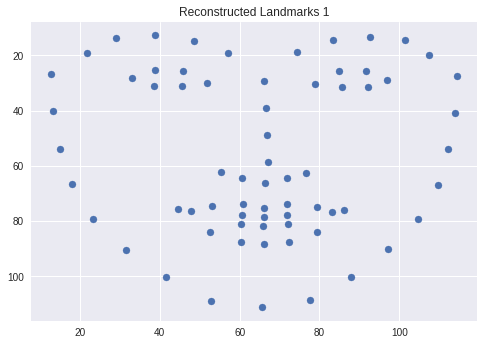

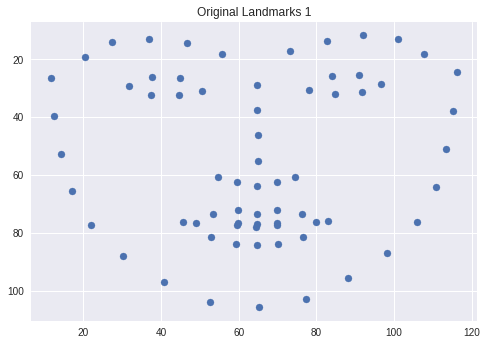

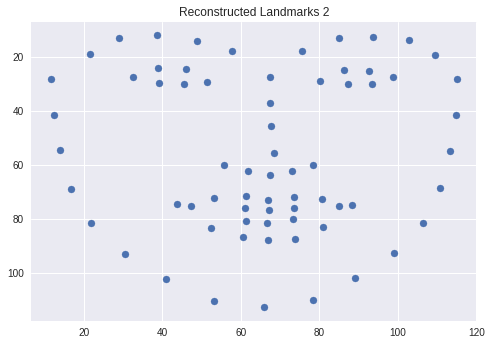

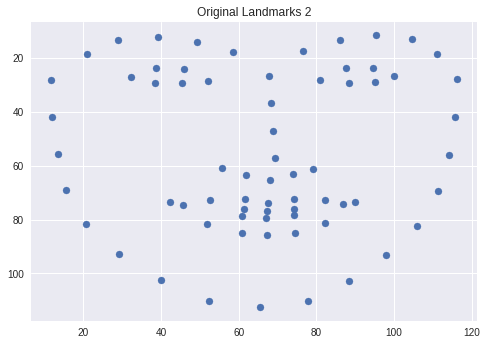

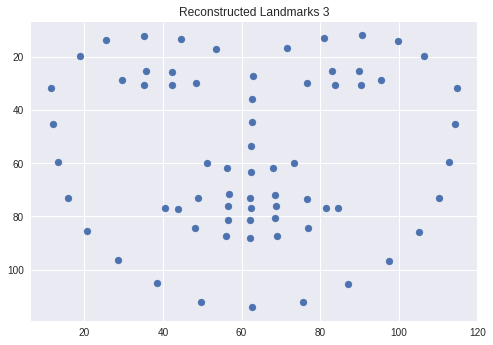

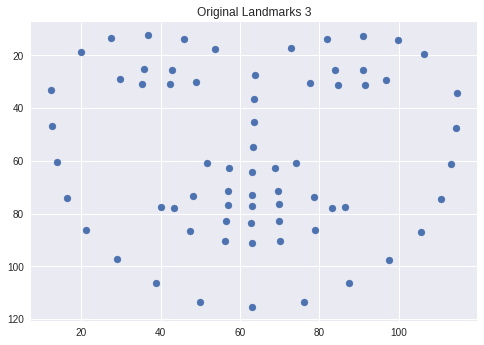

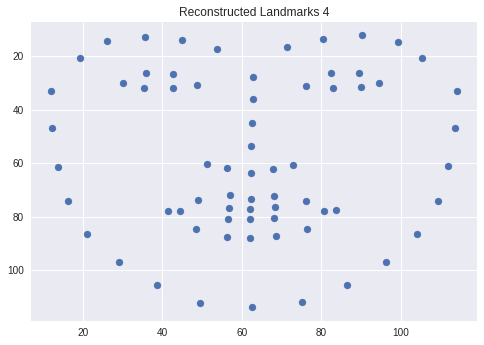

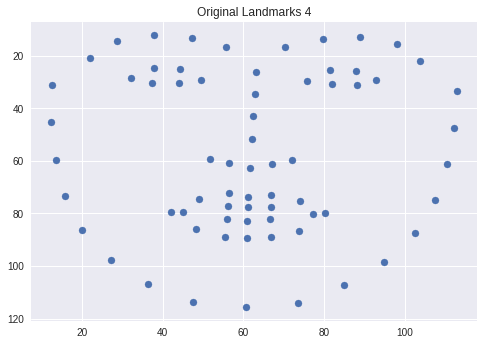

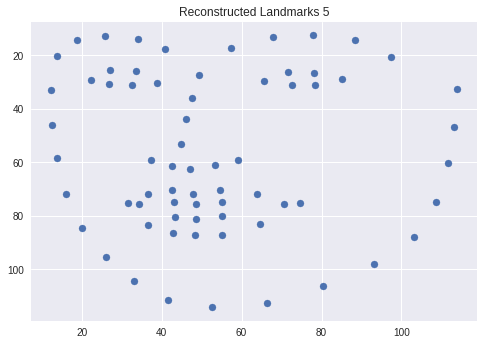

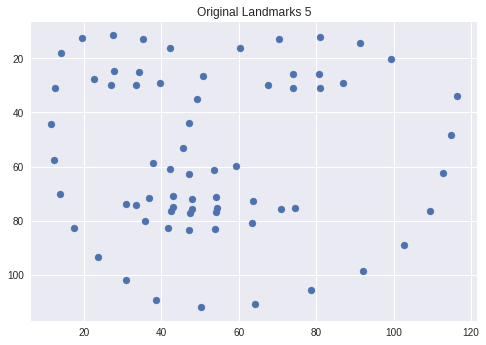

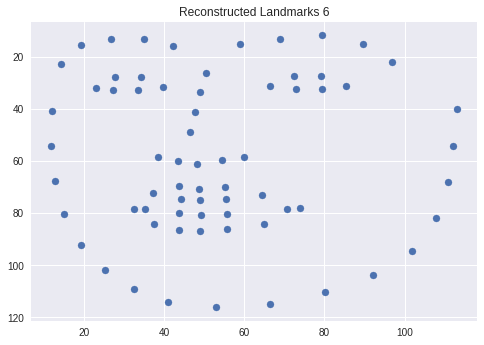

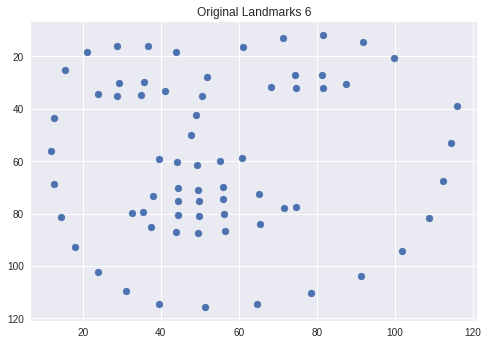

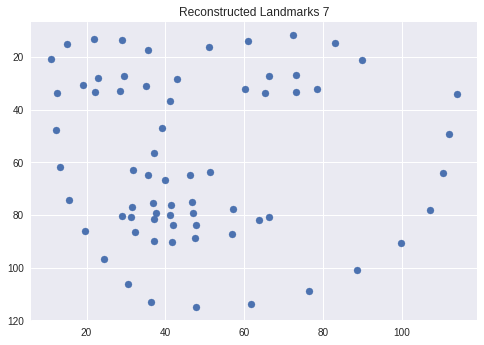

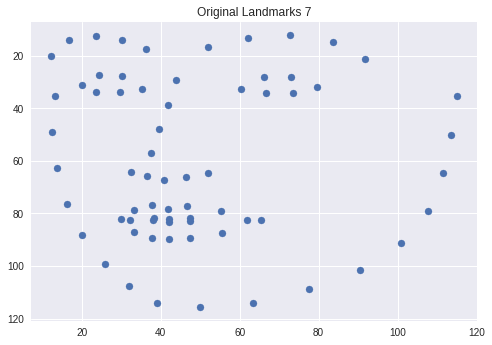

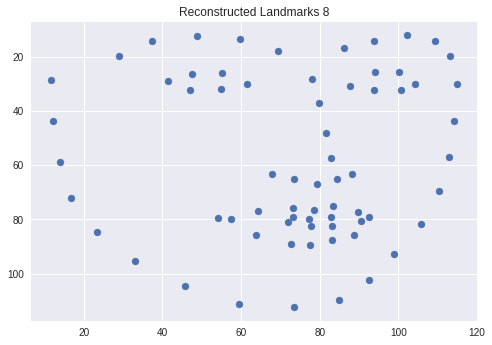

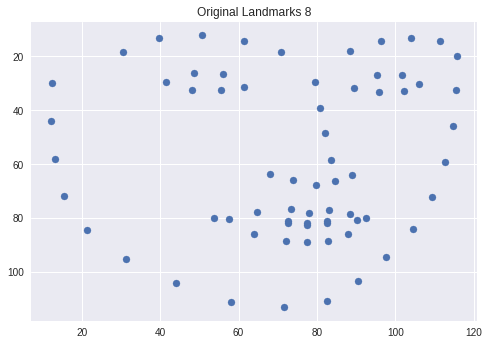

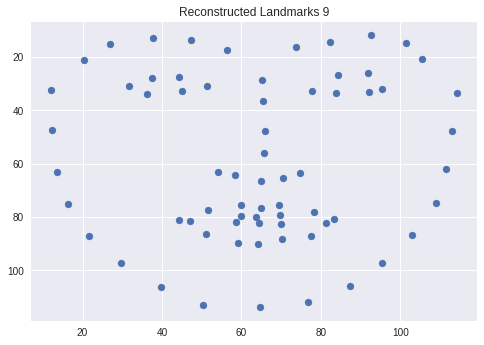

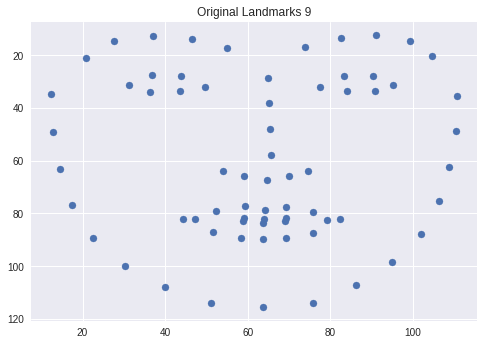

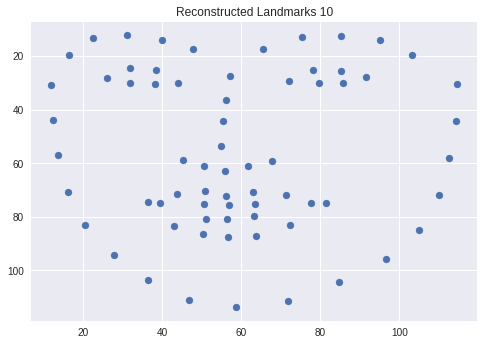

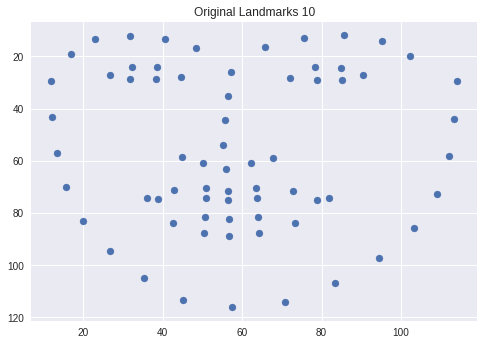

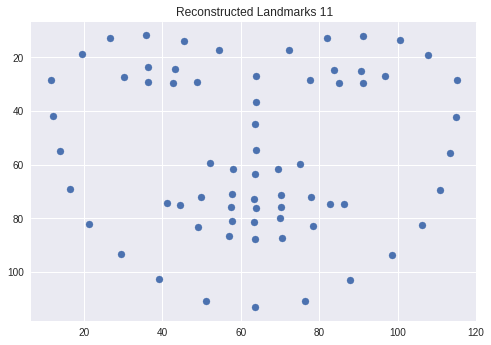

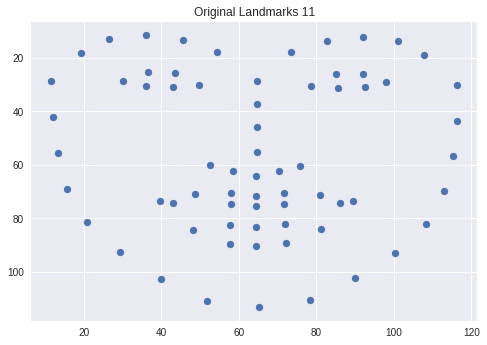

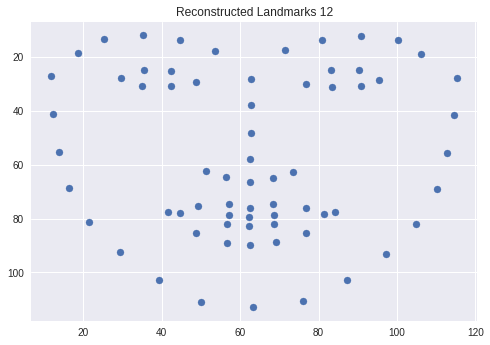

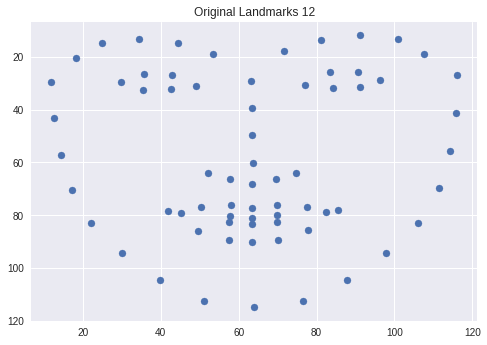

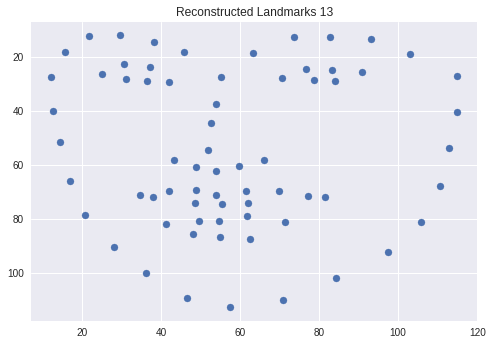

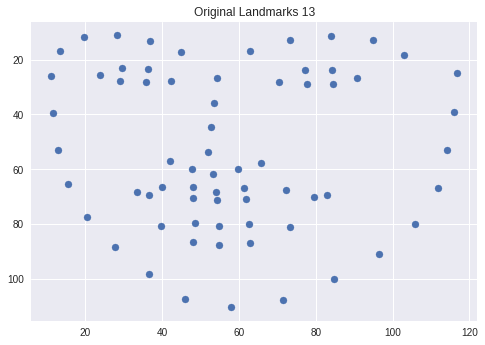

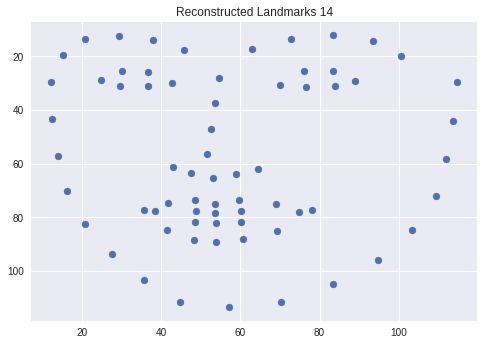

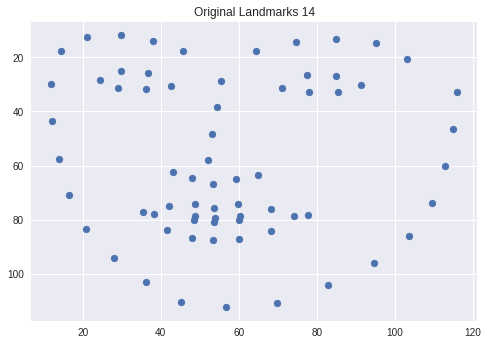

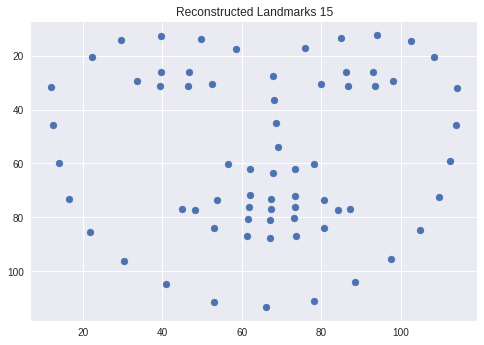

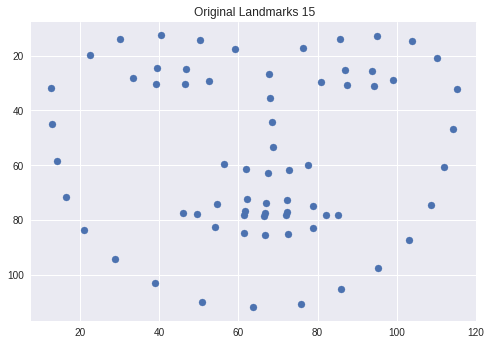

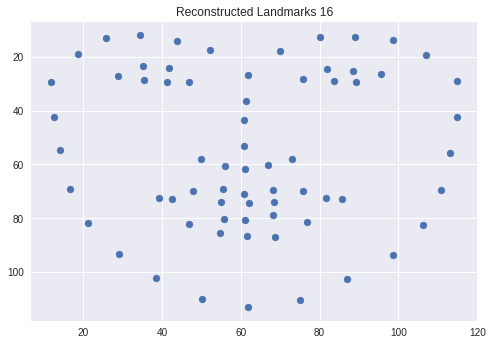

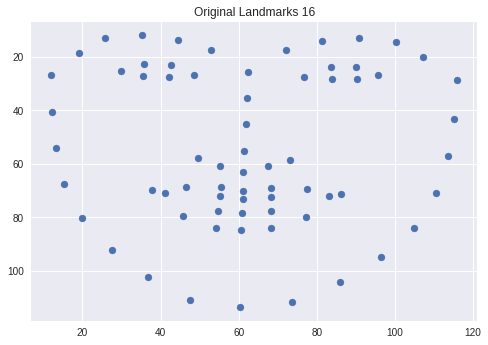

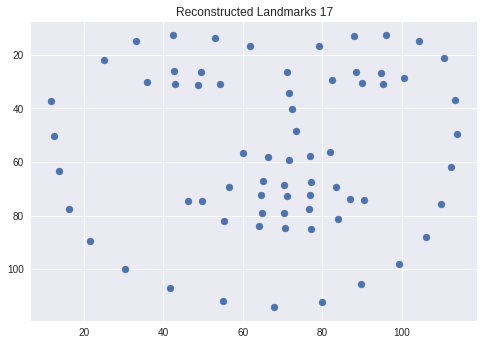

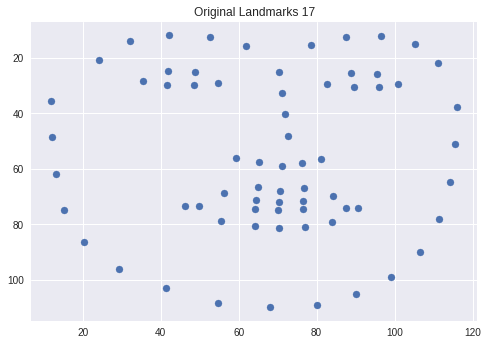

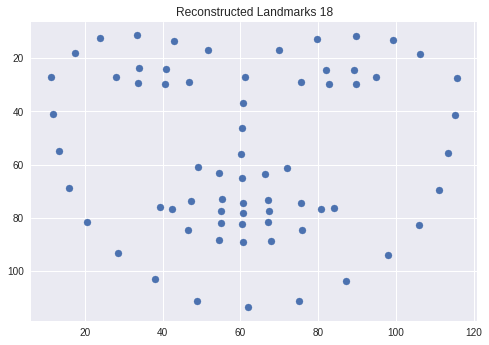

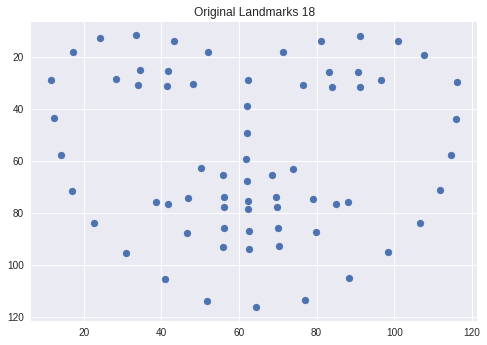

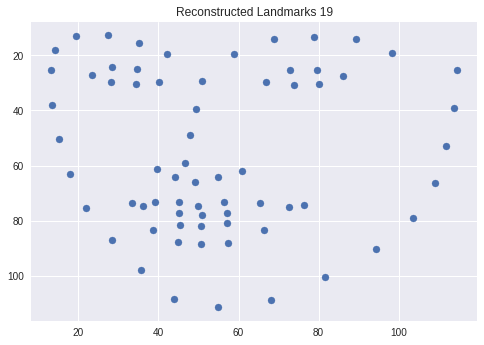

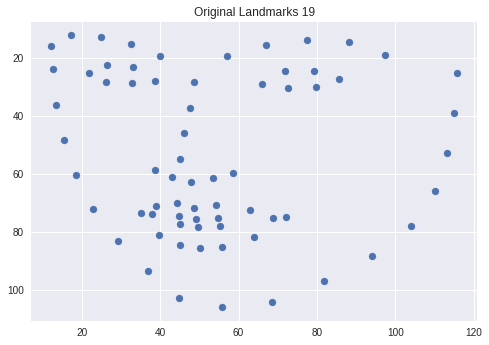

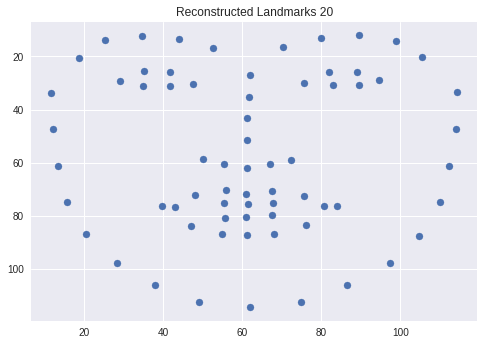

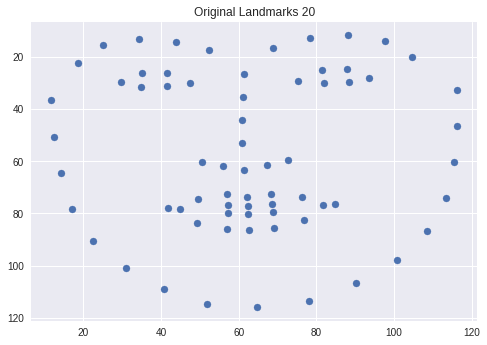

In [57]:
#Reconstructing landmarks for test images 

recon_landmarks = np.zeros(shape=(200,68,2))
with sess.as_default():
  test_num_batches = len(X_landmarks_test_norm) // batch_size
  for i in range(test_num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    recon_landmarks[start:end]=lm_x6_2_relu.eval(feed_dict={X_lm:X_landmarks_test_norm[start:end]})
  
  for j in range(20):
    plt.scatter(recon_landmarks[j, :, 0]*128, recon_landmarks[j, :, 1]*128)
    plt.title("Reconstructed Landmarks " + str(j+1))
    plt.gca().invert_yaxis()
    plt.show()
    plt.scatter(X_landmarks_test[j, :, 0], X_landmarks_test[j, :, 1])
    plt.title("Original Landmarks " + str(j+1))
    plt.gca().invert_yaxis()
    plt.show()
      

Image chosen


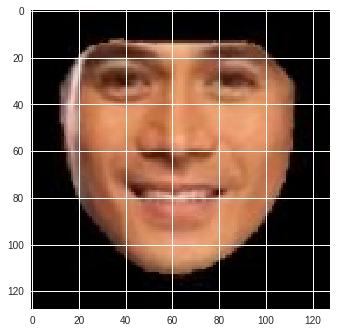

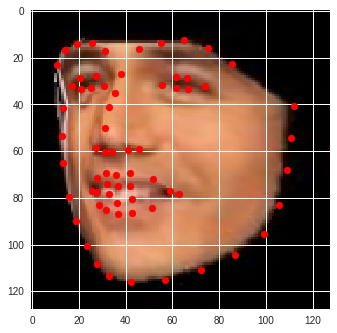

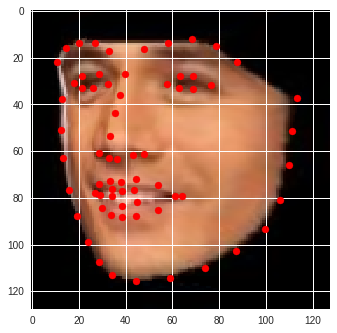

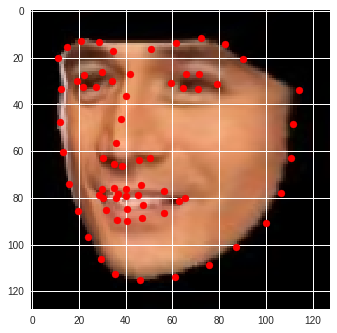

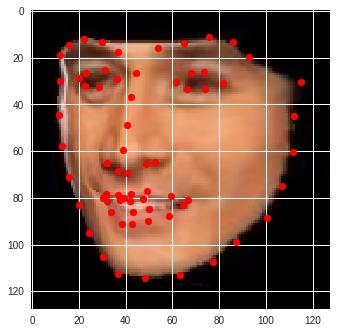

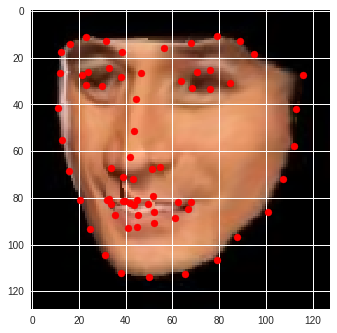

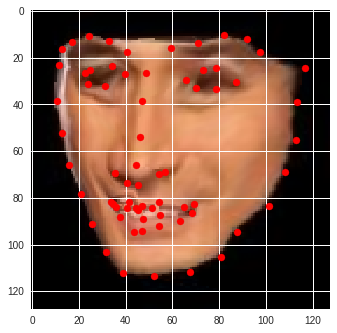

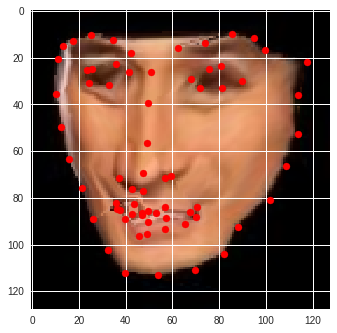

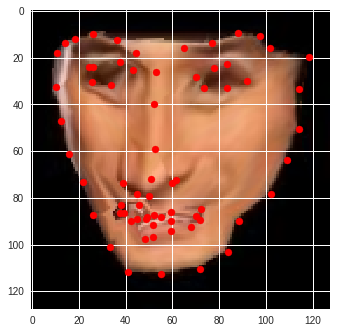

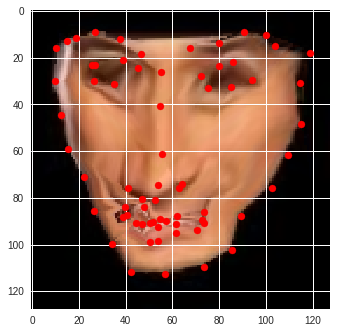

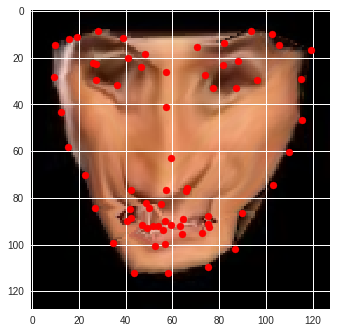

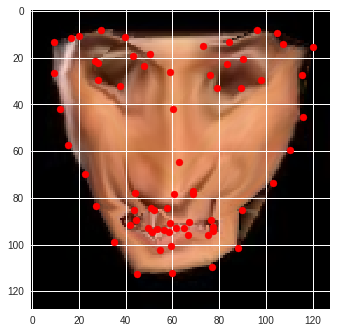

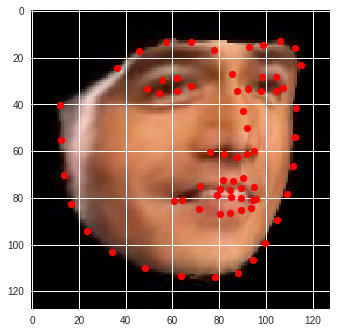

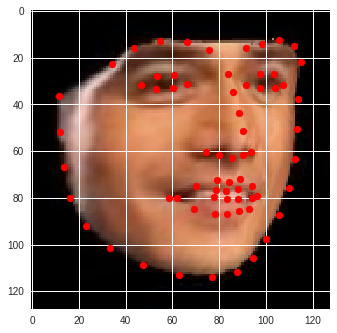

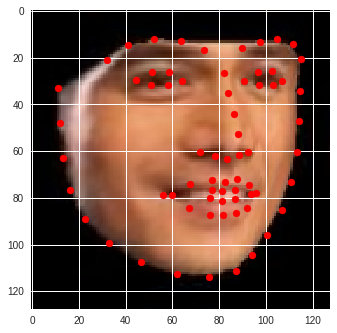

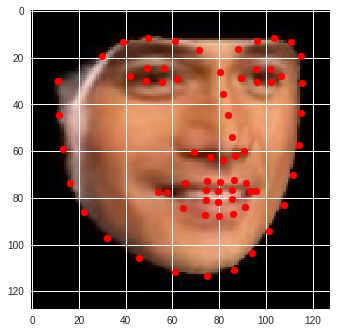

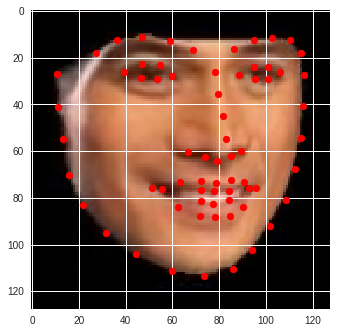

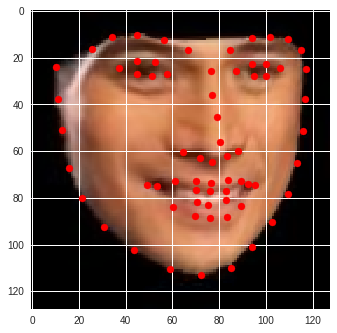

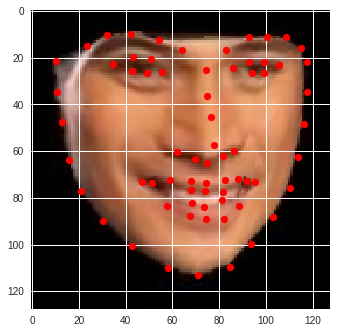

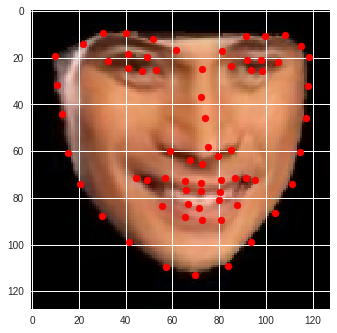

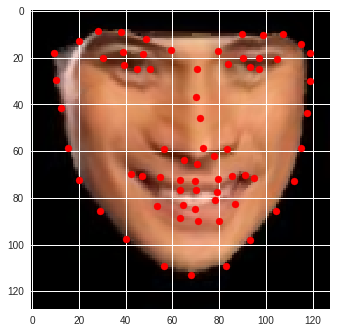

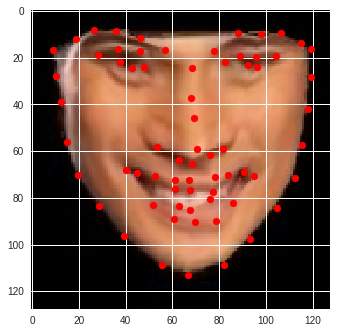

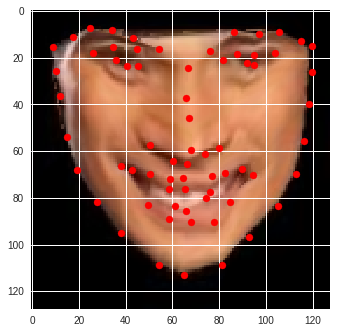

In [62]:
#Interpolation Landmarks
#2 dimensions of highest variance
#Choose an image 
im_eg = cv2.imread(my_folder+"/images/000012.jpg")
im_eg = cv2.cvtColor(im_eg, cv2.COLOR_BGR2RGB)
im_eg = mywarper.warp(im_eg, loadmat(my_folder+"/landmarks/000012.mat")['lms'], X_landmarks_mean)
print("Image chosen")
plt.imshow(im_eg)
plt.show()

latent_vec_landmarks = np.zeros((800, 10))

with sess.as_default():
  test_num_batches = len(X_landmarks_norm) // batch_size
  for i in range(test_num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    latent_vec_landmarks[start:end]=lm_x3_1_fc.eval(feed_dict={X_lm:X_landmarks_norm[start:end]})
   
  variance_vec = np.zeros((10))

  for i in range(10):
    variance_vec[i] = np.var(latent_vec_landmarks[:,i])
    
  dims_highest_variance = variance_vec.argsort()[-2:][::-1]

  
  for i in range(len(dims_highest_variance)):
    max_val_index = np.argmax(latent_vec_landmarks[:, dims_highest_variance[i]])
    min_val_index = np.argmin(latent_vec_landmarks[:, dims_highest_variance[i]])
    max_val = latent_vec_landmarks[max_val_index, dims_highest_variance[i]]
    min_val = latent_vec_landmarks[min_val_index, dims_highest_variance[i]]
    step_size = (max_val - min_val) / float(10)
    
    new_d = np.zeros((11, 10))
    for j in range(11):
      new_d[j] = latent_vec_landmarks[min_val_index]
      new_d[j, dims_highest_variance[i]] += j * step_size
      
    new_landmark = lm_x6_2_relu.eval(feed_dict={lm_x3_1_fc:new_d})
        
    for j in range(11):
      test_img = mywarper.warp(im_eg , X_landmarks_mean , new_landmark[j] * 128)
      plt.imshow(test_img)
      plt.scatter(new_landmark[j,:,0] * 128, new_landmark[j,:, 1] * 128, c='r')
      plt.show()
  

In [0]:
#Autencoder for Apperance

def kaiming_normal(shape):
    if len(shape) == 2:
        fan_in, fan_out = shape[0], shape[1]
    elif len(shape) == 4:
        fan_in, fan_out = np.prod(shape[:3]), shape[3]
    return tf.random_normal(shape) * np.sqrt(2.0 / fan_in)
   




In [0]:
#Encoder
#Convolutional layers and fully connected layers

X_ph = tf.placeholder(tf.float32, [None, 128, 128, 3])

with tf.name_scope("Encoder"):
  #Block 1
  x1_1_conv = tf.layers.conv2d(X_ph, filters = 16, kernel_size = 5, strides = 2, padding='VALID')
  x1_2_relu = tf.nn.leaky_relu(x1_1_conv)

  #Block 2
  x2_1_conv = tf.layers.conv2d(x1_2_relu, filters = 32, kernel_size = 3, strides = 2, padding='VALID')
  x2_2_relu = tf.nn.leaky_relu(x2_1_conv)

  #Block 3
  x3_1_conv = tf.layers.conv2d(x2_2_relu, filters = 64, kernel_size = 3, strides = 2, padding='VALID')
  x3_2_relu = tf.nn.leaky_relu(x3_1_conv)

  #Block 4
  x4_1_conv = tf.layers.conv2d(x3_2_relu, filters = 128, kernel_size = 3, strides = 2, padding='VALID')
  x4_2_relu = tf.nn.leaky_relu(x4_1_conv)
  
  #Block 5
  x5_1_fc = tf.contrib.layers.fully_connected(tf.contrib.layers.flatten(x4_2_relu), 50, activation_fn = tf.nn.leaky_relu)
  x5_2_relu = tf.expand_dims(x5_1_fc, axis=1)
  x5_2_relu = tf.expand_dims(x5_2_relu, axis=1)
  
with tf.name_scope("Decoder"):
  
  
  #Block 7
  x7_1_deconv = tf.layers.conv2d_transpose(x5_2_relu, filters = 128, kernel_size = 6, strides = 1, padding='VALID')
  x7_2_relu = tf.nn.leaky_relu(x7_1_deconv)

  #Block 8
  filter8 = tf.Variable(kaiming_normal([3, 3, 64, 128]),dtype=tf.float32)
  x8_1_deconv = tf.layers.conv2d_transpose(x7_2_relu,filters = 64, kernel_size = 4, strides = 2, padding='VALID')
  x8_2_relu = tf.nn.leaky_relu(x8_1_deconv)

  #Block 9
  filter9 = tf.Variable(kaiming_normal([3, 3 , 32 ,64]),dtype=tf.float32)
  x9_1_deconv = tf.layers.conv2d_transpose(x8_2_relu, filters = 32, kernel_size = 4, strides = 2, padding='VALID')
  x9_2_relu = tf.nn.leaky_relu(x9_1_deconv)
  
  #Block 10
  filter10 = tf.Variable(kaiming_normal([3, 3 , 16 ,32]),dtype=tf.float32)
  x10_1_deconv = tf.layers.conv2d_transpose(x9_2_relu, filters = 16, kernel_size = 4, strides = 2, padding='VALID')
  x10_2_relu = tf.nn.leaky_relu(x10_1_deconv)
  
  #Block 11
  filter11 = tf.Variable(kaiming_normal([5, 5 , 3 ,16]),dtype=tf.float32)
  x11_1_deconv = tf.layers.conv2d_transpose(x10_2_relu, filters = 3, kernel_size = 6, strides = 2, padding='VALID')
  x11_2_relu = tf.nn.sigmoid(x11_1_deconv)
  


In [70]:
#Training phase for appearance

loss=tf.reduce_mean(tf.square(x11_2_relu-X_ph))
learning_rate = 7e-4
optimizer=tf.train.AdamOptimizer(learning_rate)
tf_train=optimizer.minimize(loss)

init=tf.global_variables_initializer()

num_epoch=300
print("Number of Epochs " + str(num_epoch))

sess = tf.Session() 
batch_size = 100
sess.run(init)
for epoch in range(num_epoch):
  print("Epoch Number " + str(epoch))
  num_batches=800//batch_size
  for iteration in range(num_batches):
    print("Iteration Number " + str(iteration))
    stidx = iteration*batch_size
    endidx = (iteration+1)*batch_size
    sess.run(tf_train,feed_dict={X_ph:X[stidx:endidx]})
    with sess.as_default():
      train_loss=loss.eval(feed_dict={X_ph:X[stidx:endidx]})
      print("epoch {} loss {}".format(epoch,train_loss))

   
    

Number of Epochs 300
Epoch Number 0
Iteration Number 0
epoch 0 loss 0.1476021260023117
Iteration Number 1
epoch 0 loss 0.14632949233055115
Iteration Number 2
epoch 0 loss 0.14642614126205444
Iteration Number 3
epoch 0 loss 0.14778821170330048
Iteration Number 4
epoch 0 loss 0.1478136032819748
Iteration Number 5
epoch 0 loss 0.14638185501098633
Iteration Number 6
epoch 0 loss 0.1485678255558014
Iteration Number 7
epoch 0 loss 0.14667488634586334
Epoch Number 1
Iteration Number 0
epoch 1 loss 0.14613358676433563
Iteration Number 1
epoch 1 loss 0.144547238945961
Iteration Number 2
epoch 1 loss 0.14402538537979126
Iteration Number 3
epoch 1 loss 0.14465636014938354
Iteration Number 4
epoch 1 loss 0.14308159053325653
Iteration Number 5
epoch 1 loss 0.13801555335521698
Iteration Number 6
epoch 1 loss 0.13342583179473877
Iteration Number 7
epoch 1 loss 0.12065815180540085
Epoch Number 2
Iteration Number 0
epoch 2 loss 0.10790877044200897
Iteration Number 1
epoch 2 loss 0.09435855597257614
Ite

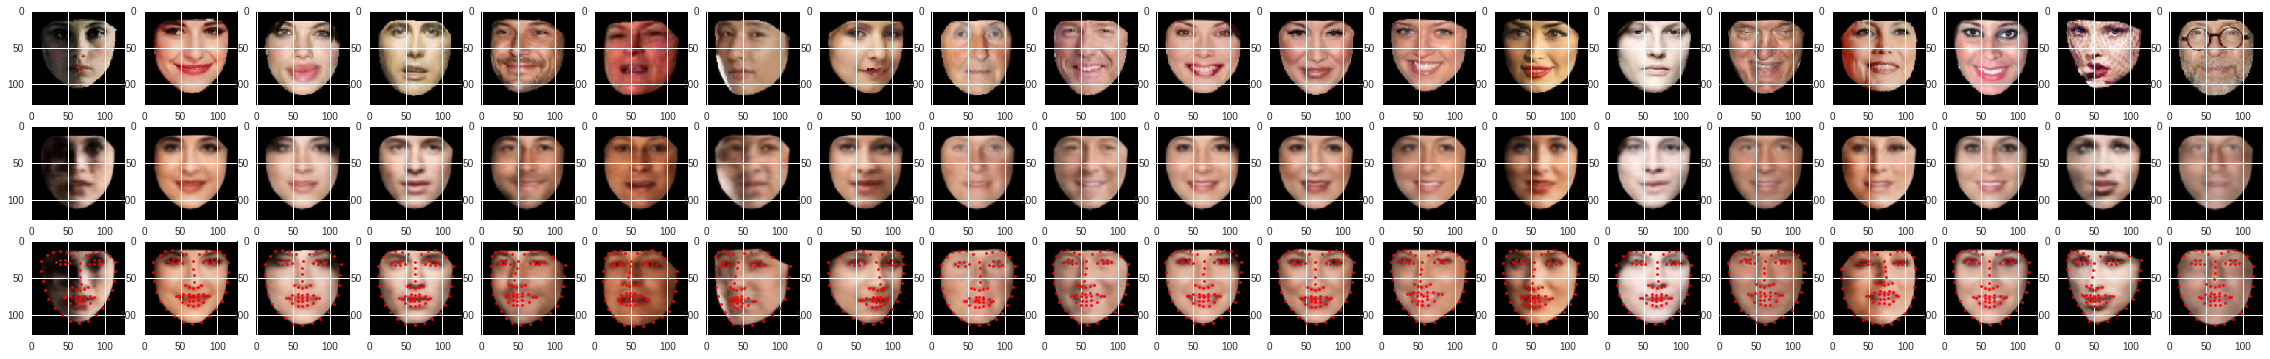

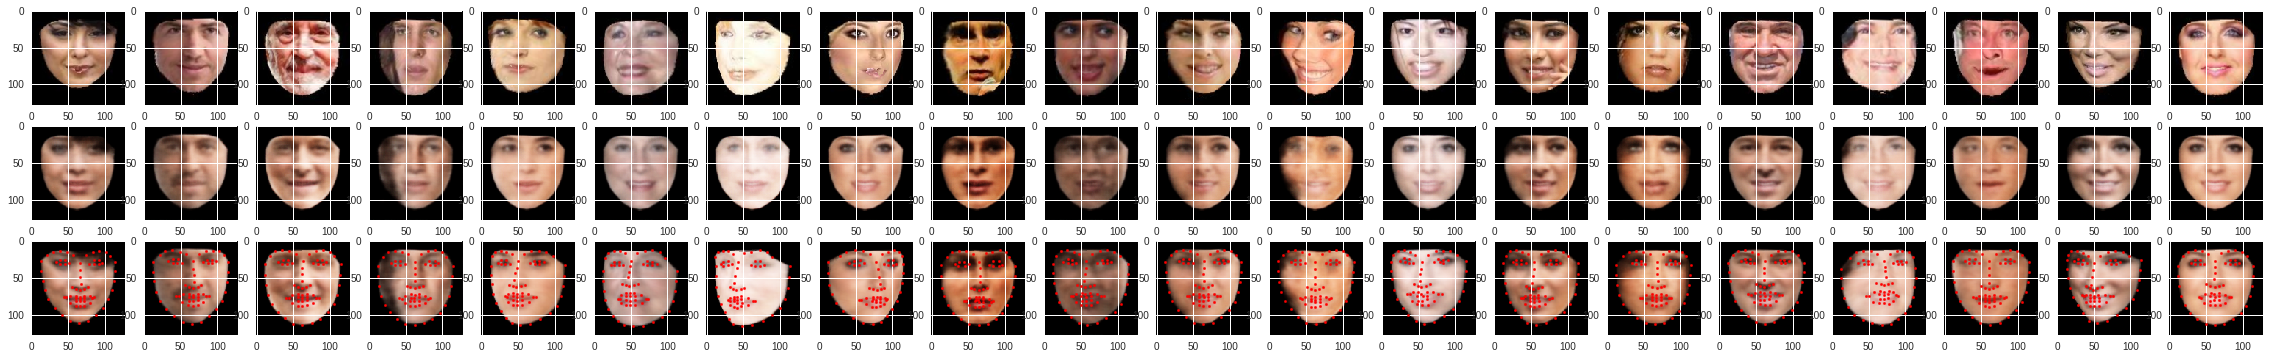

In [71]:
#Reconstructing appearance for test images 
with sess.as_default():
  test_num_batches = len(X_test) // batch_size
  for i in range(test_num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    results=x11_2_relu.eval(feed_dict={X_ph:X_test[start:end]})
    num_test_images = end - start + 1
    fig,axs=plt.subplots(3,20,figsize=(40,6), squeeze = False)
    for j in range(20):
        unwarped_org = mywarper.warp(X_test[start + j], X_landmarks_mean, X_landmarks_test[j])
        axs[0][j].imshow(unwarped_org)
        axs[1][j].imshow(results[j])
        warpedtest = mywarper.warp(results[j], X_landmarks_mean, recon_landmarks[j]*128)
        axs[2][j].imshow(warpedtest)
        axs[2][j].scatter(recon_landmarks[j,:,0]*128, recon_landmarks[j,:,1]*128, s = 6, c = 'r')

      

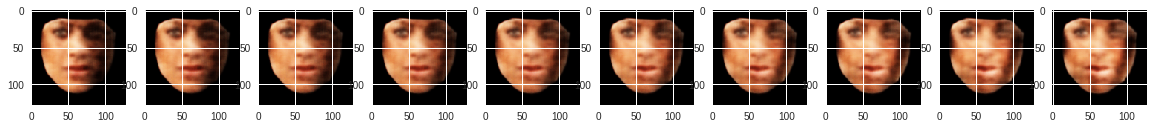

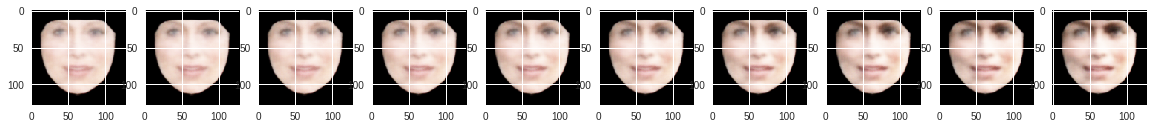

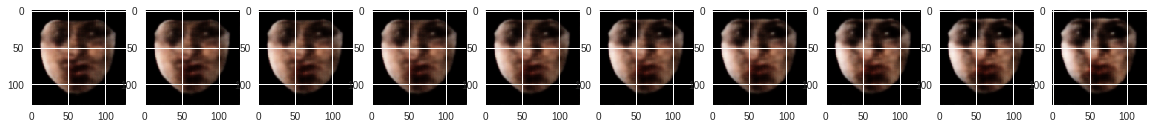

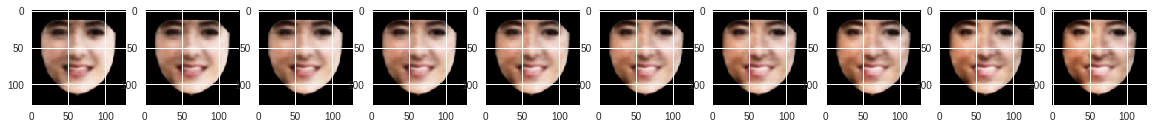

In [72]:
#Interpolation for appearance of images 
#4 dimensions of highest variance


recon_op = np.zeros((800, 1, 1, 50))
with sess.as_default():
  test_num_batches = len(X_test) // batch_size
  for i in range(test_num_batches):
    stind = i * batch_size
    endind = (i + 1) * batch_size
    recon_op[stind:endind]= sess.run(x5_2_relu,feed_dict={X_ph:X_test[stind:endind]})
   
  variance_vec = np.zeros((50))

  for i in range(50):
    variance_vec[i] = np.var(recon_op[:, :, :, i])
    
  variance_highest = variance_vec.argsort()[-4:][::-1]
  
  for i in range(len(variance_highest)):
    max_val_index = np.argmax(recon_op[:, :, :, variance_highest[i]])
    min_val_index = np.argmin(recon_op[:, :, :, variance_highest[i]])
    max_val = recon_op[max_val_index, :, :, variance_highest[i]]
    min_val = recon_op[min_val_index, :, :, variance_highest[i]]
    step_size = (max_val - min_val) / float(10)
    new_d = np.zeros((10, 1, 1, 50))
    for j in range(10):
      new_d[j] = recon_op[min_val_index]
      new_d[j, :, :, variance_highest[i]] += j * step_size    
    new_interpol = x11_2_relu.eval(feed_dict={x5_2_relu:new_d})
    f,a=plt.subplots(1,10,figsize=(20,4), squeeze = False)
    for j in range(10):
        a[0, j].imshow(new_interpol[j])

In [0]:
#END